In [36]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import geopandas as gpd
from ipyleaflet import Map, basemaps, basemap_to_tiles, Heatmap
import seaborn as sns


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Introduction

This notebook is a part of the project "EDA of the dataset of King County Housing". The dataset is available on Kaggle. The dataset contains information about houses in King County, Seattle from May 2014 to May 2015. The dataset contains 21 variables and 21597 observations. The goal of this project is to explore the dataset and find out the factors that affect the price of the houses, while aming to help low income families to buy at the rigth time and location. 

In [3]:
df = pd.read_csv("./data/eda.csv")
df.shape

(21597, 21)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   bedrooms       21597 non-null  float64
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  float64
 4   sqft_lot       21597 non-null  float64
 5   floors         21597 non-null  float64
 6   waterfront     19206 non-null  float64
 7   view           21534 non-null  float64
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  float64
 11  sqft_basement  21145 non-null  float64
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   17749 non-null  float64
 14  zipcode        21597 non-null  int64  
 15  lat            21597 non-null  float64
 16  long           21597 non-null  float64
 17  sqft_living15  21597 non-null  float64
 18  sqft_l

In [5]:
df.head(5)

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date,price
0,7129300520,3.000,1.000,1180.000,5650.000,1.000,NaN,0.000,3,7,...,0.000,1955,0.000,98178,47.511,-122.257,1340.000,5650.000,2014-10-13,221900.000
1,6414100192,3.000,2.250,2570.000,7242.000,2.000,0.000,0.000,3,7,...,400.000,1951,19910.000,98125,47.721,-122.319,1690.000,7639.000,2014-12-09,538000.000
2,5631500400,2.000,1.000,770.000,10000.000,1.000,0.000,0.000,3,6,...,0.000,1933,NaN,98028,47.738,-122.233,2720.000,8062.000,2015-02-25,180000.000
3,2487200875,4.000,3.000,1960.000,5000.000,1.000,0.000,0.000,5,7,...,910.000,1965,0.000,98136,47.521,-122.393,1360.000,5000.000,2014-12-09,604000.000
4,1954400510,3.000,2.000,1680.000,8080.000,1.000,0.000,0.000,3,8,...,0.000,1987,0.000,98074,47.617,-122.045,1800.000,7503.000,2015-02-18,510000.000


## 1. Data Cleaning and Preparation

### Handle Missing values

In [6]:
df.isna().sum()

id                  0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2391
view               63
condition           0
grade               0
sqft_above          0
sqft_basement     452
yr_built            0
yr_renovated     3848
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
date                0
price               0
dtype: int64

In [7]:
df.fillna(0, inplace=True)

### Handle Outliers

In [8]:
# . quantiles for prices 
df["price"].quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

0.010    154000.000
0.050    210000.000
0.250    322000.000
0.500    450000.000
0.750    645000.000
0.950   1160000.000
0.990   1970000.000
Name: price, dtype: float64

<Axes: xlabel='price'>

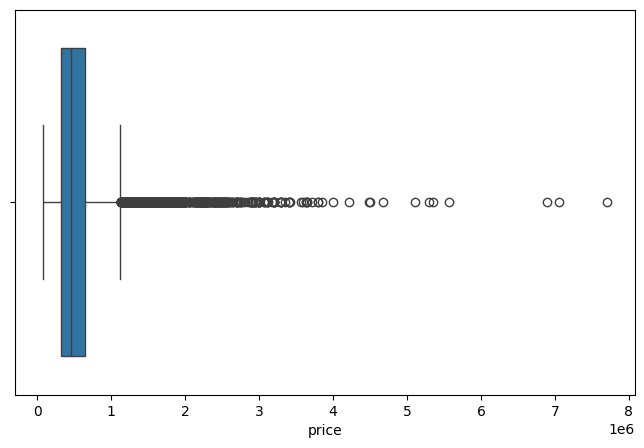

In [9]:
# Boxplot for price
sns.boxplot(x=df["price"])

In [13]:
# identiy outliers using IQR method
Q1 = df["price"].quantile(0.25)
Q3 = df["price"].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df["price"] < (Q1 - 1.5 * IQR)) |(df["price"] > (Q3 + 1.5 * IQR)))]
df['price'].describe()

count     19908.000
mean     464473.477
std      194268.278
min       78000.000
25%      312000.000
50%      430000.000
75%      587126.500
max     1010000.000
Name: price, dtype: float64

In [12]:
# Handle outliers for sqft_living
Q1 = df["sqft_living"].quantile(0.25)
Q3 = df["sqft_living"].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df["sqft_living"] < (Q1 - 1.5 * IQR)) |(df["sqft_living"] > (Q3 + 1.5 * IQR)))]
df["sqft_living"].describe()

count   20120.000
mean     1936.277
std       712.217
min       370.000
25%      1390.000
50%      1840.000
75%      2400.000
max      3970.000
Name: sqft_living, dtype: float64

### Handle Date data

In [14]:
df['yr_renovated'].value_counts()

yr_renovated
0.000        19311
20140.000       64
20130.000       27
20000.000       24
20070.000       23
             ...  
19710.000        1
19340.000        1
19540.000        1
19440.000        1
19500.000        1
Name: count, Length: 70, dtype: int64

In [15]:
df['yr_renovated'] = df['yr_renovated'].astype(str)

In [16]:
df['yr_renovated'] = df['yr_renovated'].str.strip('00.*')

In [17]:
# replace '.' with nan
df['yr_renovated'] = df['yr_renovated'].replace('.', np.nan)

In [20]:
# fix year with 3 digit values add zero at the end
df['yr_renovated'] = df['yr_renovated'].apply(lambda x: x + '0' if len(x) <= 3 else x)

In [23]:
# find all less than 3 digit values
df['yr_renovated'][df['yr_renovated'].str.len() < 4].value_counts()

yr_renovated
00    19311
Name: count, dtype: int64

In [22]:
# fix values of 200 to 2000
df['yr_renovated'] = df['yr_renovated'].replace('200', '2000')

In [24]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [25]:
df['yr_renovated'][0:10]

0       00
1     1991
2       00
3       00
4       00
6       00
7       00
8       00
9       00
10      00
Name: yr_renovated, dtype: object

In [26]:
df.duplicated().value_counts()

False    19908
Name: count, dtype: int64

### Handle categorial data

In [27]:
df['waterfront'] = df['waterfront'].astype('bool')

In [28]:
df['view'] = df['view'].astype('bool')

In [29]:
df[['condition','grade','zipcode']] = df[['condition','grade','zipcode']].astype('category')

### Univariant Analysis

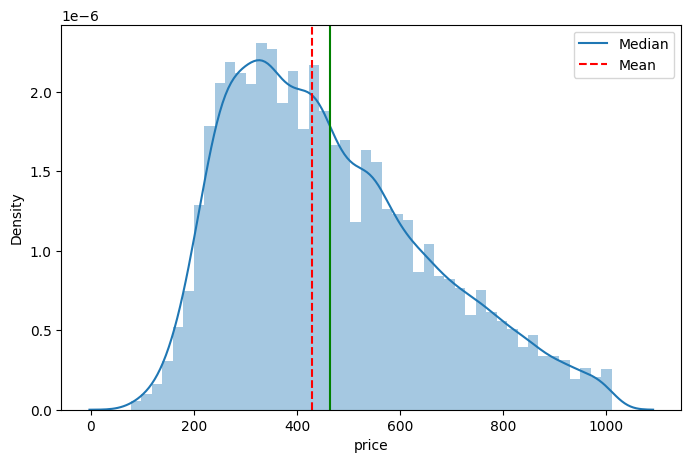

In [37]:
# Price distribution with median and mean

fig, ax = plt.subplots()
sns.distplot(df['price'], ax=ax)
ax.axvline(df['price'].median(), color='r', linestyle='--')
ax.axvline(df['price'].mean(), color='g', linestyle='-')
# values of price in x-axis in thousands to make it readable
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x/1000)))
plt.legend({'Median':df['price'].median(),'Mean':df['price'].mean()})
plt.show()

After removing the outliers, we can see that the price is right skewed. The mean is 540088.14 and the median is 450000. The standard deviation is 367118.7. The price ranges from 75000 to 1960000.

<Axes: xlabel='decade', ylabel='count'>

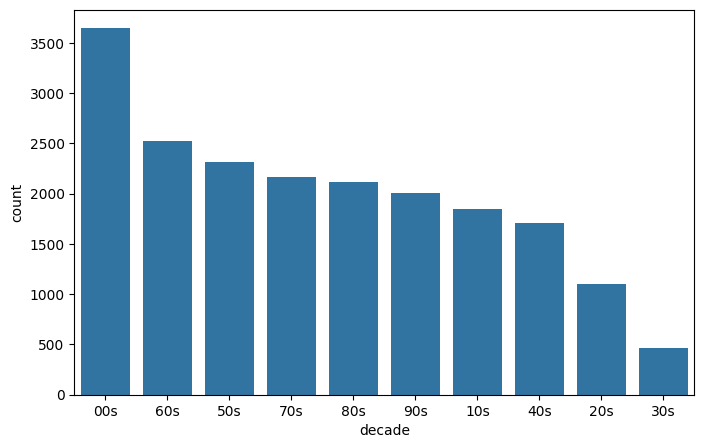

In [38]:
df['decade'] = df['yr_built'].apply(lambda x: str(x)[2:3] + '0s')
sns.countplot(x="decade", data=df, order=df['decade'].value_counts().index)

In [39]:
# Barplot by year renovated by percentage
df['renovated'] = df['yr_renovated'].apply(lambda x: 1 if x != 'nan' else 0)
df['renovated'].value_counts()

renovated
1    19908
Name: count, dtype: int64

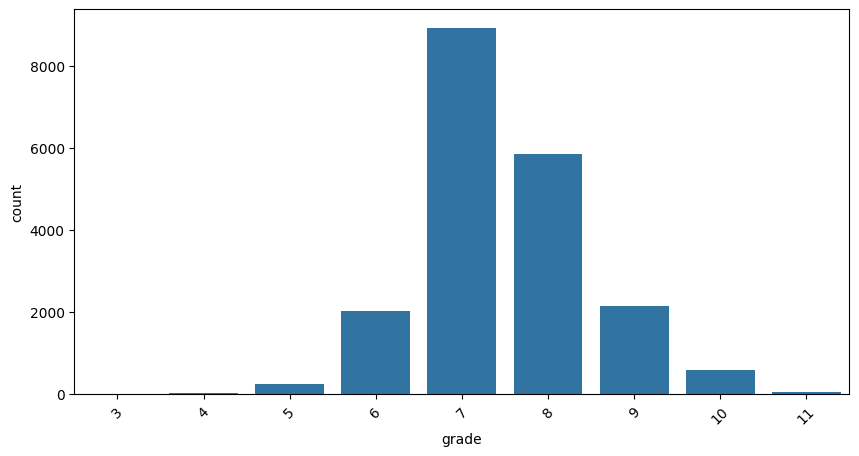

In [40]:
# Barplot grade
plt.figure(figsize=(10,5))
sns.countplot(x=df["grade"])
plt.xticks(rotation=45);

<Axes: xlabel='condition', ylabel='count'>

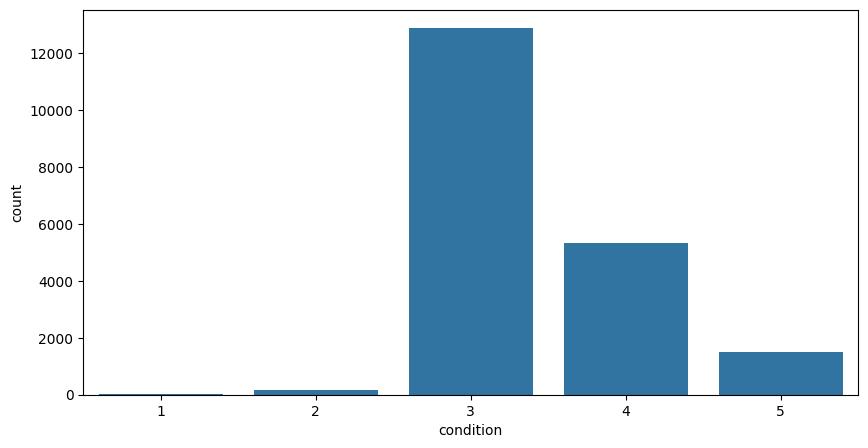

In [42]:
# barplot for condition
plt.figure(figsize=(10,5))
sns.countplot(x=df["condition"])

### Bi-variant analysis

<Axes: xlabel='sqft_living', ylabel='price'>

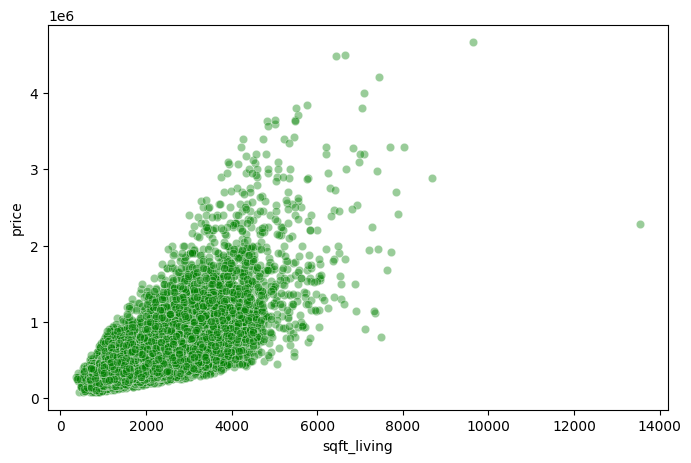

In [51]:
# Bivariate analysis
# plot price x sqft_living
sns.scatterplot(x=df['sqft_living'], y=df['price'], color='g', alpha=0.4)

<Axes: xlabel='sqft_lot', ylabel='price'>

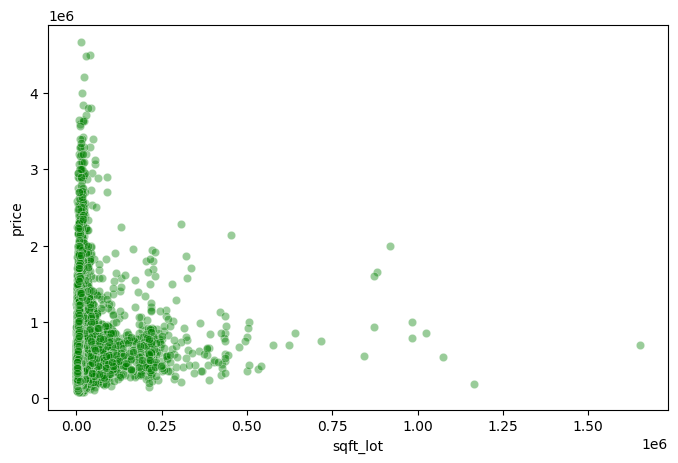

In [52]:

# plot price x sqft_lot
sns.scatterplot(x=df['sqft_lot'], y=df['price'], color='g', alpha=0.4)


<Axes: xlabel='sqft_above', ylabel='price'>

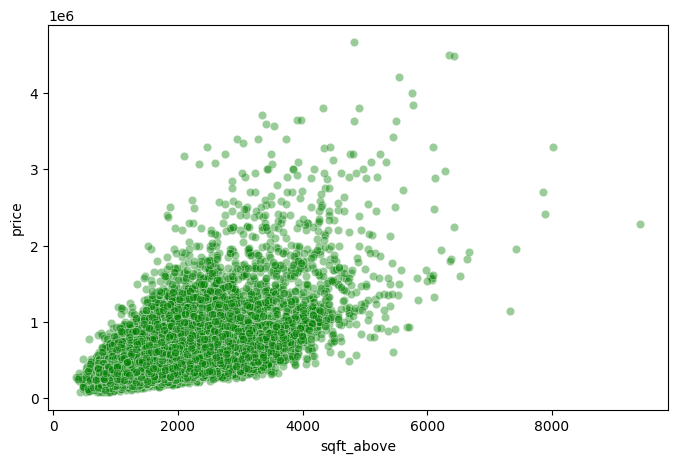

In [53]:

# plot price x sqft_above
sns.scatterplot(x=df['sqft_above'], y=df['price'], color='g', alpha=0.4)

<Axes: xlabel='sqft_basement', ylabel='price'>

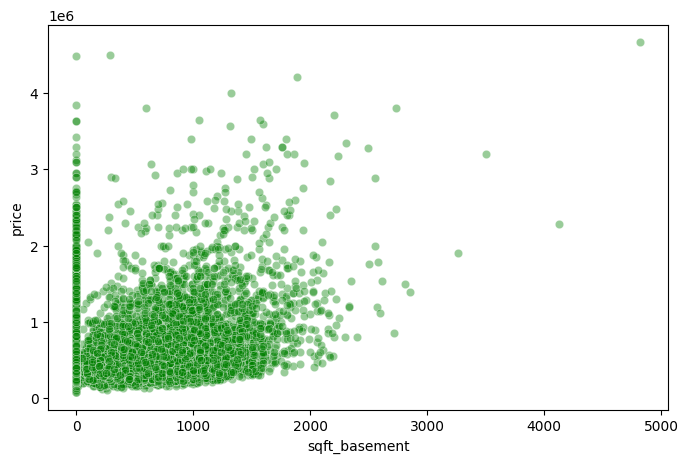

In [54]:
# plot price x sqft_basement
sns.scatterplot(x=df['sqft_basement'], y=df['price'], color='g', alpha=0.4)

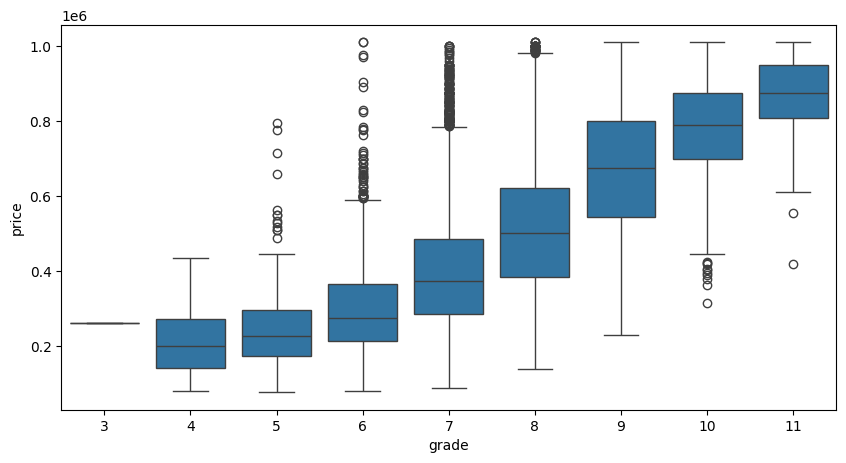

In [43]:
# Boxplot price vs grade
plt.figure(figsize=(10,5))
sns.boxplot(x=df["grade"], y=df["price"]);

<Axes: xlabel='condition', ylabel='price'>

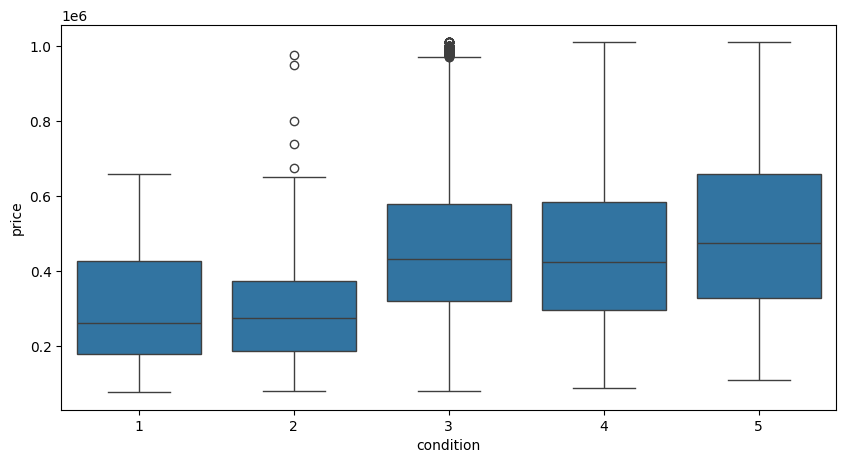

In [44]:
# Boxplot price vs condition
plt.figure(figsize=(10,5))
sns.boxplot(x=df["condition"], y=df["price"])

In [45]:
df[['bedrooms','sqft_living','floors','sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15']].describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,19908.000,3.308,0.897,1.000,3.000,3.000,4.000,33.000
sqft_living,19908.000,1925.178,705.312,370.000,1390.000,1830.000,2390.000,3970.000
floors,19908.000,1.466,0.536,1.000,1.000,1.000,2.000,3.500
sqft_lot,19908.000,13973.189,37864.266,520.000,5000.000,7480.000,10186.250,1651359.000
sqft_above,19908.000,1669.301,677.257,370.000,1168.750,1500.000,2050.000,3970.000
sqft_basement,19908.000,250.565,389.467,0.000,0.000,0.000,490.000,1990.000
sqft_living15,19908.000,1893.365,582.059,399.000,1460.000,1780.000,2240.000,4950.000
sqft_lot15,19908.000,12034.494,24958.577,651.000,5020.000,7500.000,9775.000,560617.000


In [46]:
# Create a new column for total sqft
df['sqft_total'] = df['sqft_living'] + df['sqft_lot'] + df['sqft_above'] + df['sqft_basement'] + df['sqft_living15'] + df['sqft_lot15']

df['price_per_sqft'] = df['price']/df['sqft_total']

df['price_per_sqft'].describe()

count   19908.000
mean       24.481
std        16.328
min         0.160
25%        12.908
50%        20.339
75%        32.094
max       133.686
Name: price_per_sqft, dtype: float64

<Axes: xlabel='price_per_sqft', ylabel='Density'>

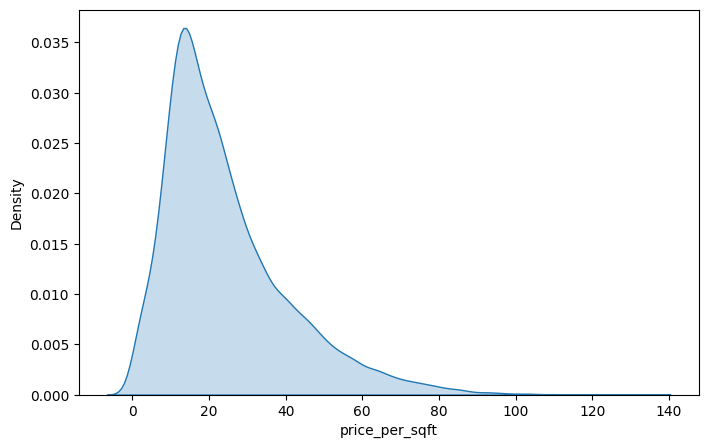

In [47]:
# scater plot for price per sqft
sns.kdeplot(df['price_per_sqft'], shade=True)

In [48]:
# Subset the data group by zipcode and price_per_sqft in ascending order
df_zipcode = df.groupby('zipcode')['price_per_sqft'].mean().sort_values(ascending=False).reset_index()

df_zipcode.head()

,zipcode,price_per_sqft
0,98102,66.252
1,98109,60.754
2,98119,60.401
3,98112,56.640
4,98107,54.025


<Axes: >

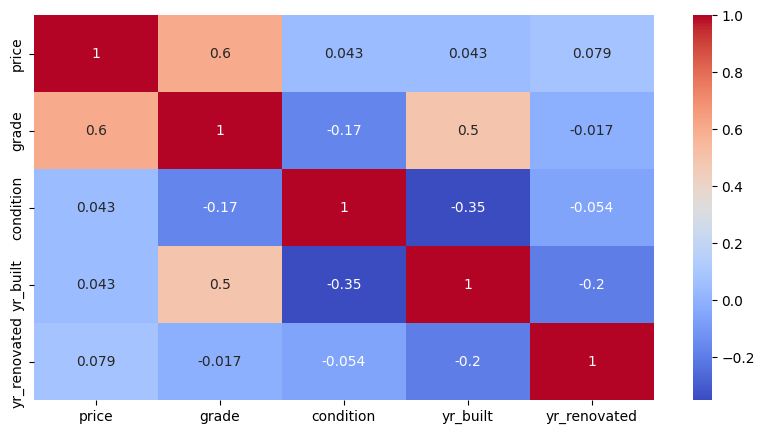

In [50]:
# heatmap for price per sqft, grade, condition, yr_built, yr_renovated and zipcode
plt.figure(figsize=(10,5))
sns.heatmap(df[['price','grade','condition','yr_built','yr_renovated']].corr(), annot=True, cmap='coolwarm')

In [51]:

df_dimensions = df[['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15']]

In [52]:
df_location = df[['lat','long','zipcode','grade','condition','price']]

In [53]:
df_time = df[['date','yr_built','yr_renovated','price']]

### Geofraphical Analysis


In [54]:
# Plot price in map with geopandas
# Load the map of King County
king_county = gpd.read_file('./data/king_county_map/Zipcodes_for_King_County_and_Surrounding_Area.shp')
king_county.head()


,OBJECTID,ZIP,ZIPCODE,COUNTY,ZIP_TYPE,COUNTY_NAM,PREFERRED_,Shape_Leng,Shape_Area,geometry
0,1,98001,98001,033,Standard,King County,AUBURN,147536.710,525368924.161,"POLYGON ((-122.29032 47.35495, -122.28851 47.3..."
1,2,98002,98002,033,Standard,King County,AUBURN,104440.087,205302754.220,"POLYGON ((-122.22820 47.35395, -122.22546 47.3..."
2,3,98003,98003,033,Standard,King County,FEDERAL WAY,123733.571,316942629.489,"POLYGON ((-122.30392 47.35794, -122.30393 47.3..."
3,4,98004,98004,033,Standard,King County,BELLEVUE,99325.952,250745415.523,"POLYGON ((-122.21189 47.64635, -122.21189 47.6..."
4,5,98005,98005,033,Standard,King County,BELLEVUE,116554.738,211433669.434,"MULTIPOLYGON (((-122.15354 47.66056, -122.1534..."


In [55]:

# Convert the 'ZIP' column to integers
king_county['ZIP'] = king_county['ZIP'].astype(int)

In [56]:
# Merge the dataframes
king_county = king_county.merge(df, left_on='ZIP', right_on='zipcode', how='left')

In [57]:
# subset the data by zipcode using df_zipcode
king_county = king_county[king_county['ZIP'].isin(df_zipcode['zipcode'])]

<Axes: >

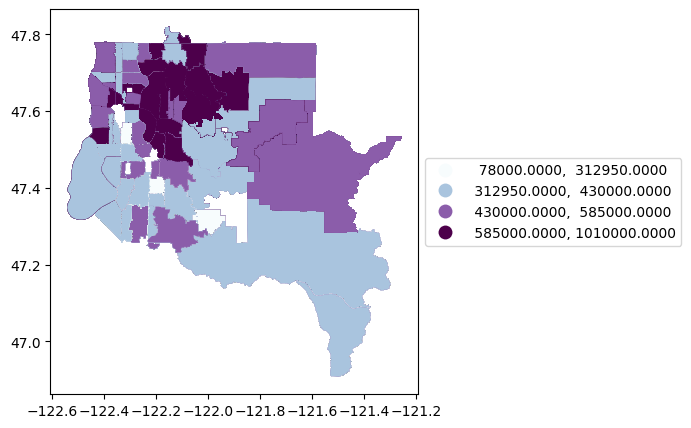

In [58]:
# Plot the data
king_county.plot(
    column="price",
    scheme="QUANTILES",
    k=4,
    cmap="BuPu",
    legend=True,
    legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5), "fmt": "{:.4f}"},
)

In [59]:
# plot with ipyleaflet
m = Map(center=(47.5, -122.2), zoom=9, basemap=basemaps.OpenStreetMap.Mapnik)

heatmaps = Heatmap(
    locations=df[['lat', 'long']].values.tolist(),
    z=df['price'].values.tolist(),
    radius=8,
    max=0.1
)

m.add_layer(basemap_to_tiles(basemaps.OpenStreetMap.BlackAndWhite))
m.add_layer(heatmaps)
m


Map(center=[47.5, -122.2], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [50]:
#save the map
m.save('map.html')

<Axes: >

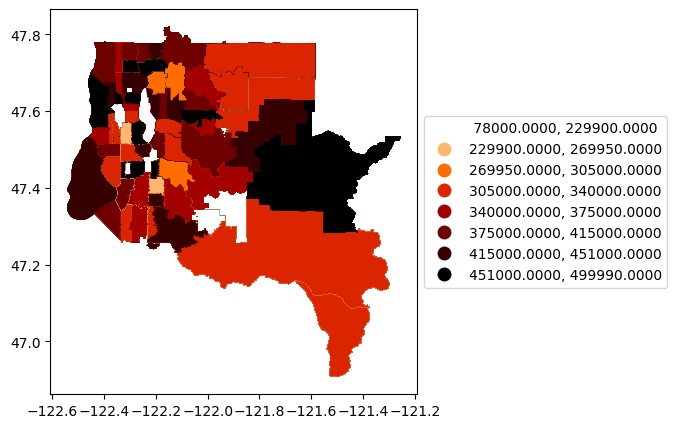

In [60]:
# subset of data by zipcode with price lower than 500000
df_zipcode = df[df['price'] < 500000]

# plot price x zipcode in map with geopandas
# Load the map of King County
king_county = gpd.read_file('./data/king_county_map/Zipcodes_for_King_County_and_Surrounding_Area.shp')
king_county.head()

# Convert the 'ZIP' column to integers
king_county['ZIP'] = king_county['ZIP'].astype(int)

# Merge the dataframes
king_county = king_county.merge(df_zipcode, left_on='ZIP', right_on='zipcode', how='left')

# Plot the data
king_county.plot(
    column="price",
    scheme="QUANTILES",
    k=8,
    cmap="gist_heat_r",
    legend=True,
    legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5), "fmt": "{:.4f}"},
)

In [36]:
# lower price by zipcode
df_zipcode['price'].groupby(df_zipcode['zipcode']).mean().sort_values(ascending=False).head(10)

zipcode
98075   457089.375
98005   456475.429
98105   451618.000
98107   446498.411
98119   443703.318
98007   434219.106
98029   431247.611
98052   429222.955
98112   429097.105
98109   427867.857
Name: price, dtype: float64